In [ ]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from tqdm import tqdm
import os
import random
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels = {'calm':0,'uncalm':1}

In [ ]:
x_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Binary Classification Learn Dataset/01062023/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(labels[i])

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 511/511 [00:18<00:00, 28.29it/s]


In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.20,random_state=1321)

In [ ]:
print(y_train)

[1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0
 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0
 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1
 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0
 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1
 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0
 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0
 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1
 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0
 1 1 0 1 0 1 0 0 0 1 0 1 

In [ ]:
# DATA
NUM_CLASSES = 1
INPUT_SHAPE = (32, 32, 3)
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.00001

# TRAINING
EPOCHS = 250

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 8
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [
    2048,
    1024
]

In [ ]:
train_data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="train_data_augmentation",
)

test_data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="test_data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
train_data_augmentation.layers[0].adapt(x_train)
test_data_augmentation.layers[0].adapt(x_train)

In [ ]:
def map_fn_train(image, label):
    return (train_data_augmentation(image), label)

def map_fn_test(image, label):
    return (test_data_augmentation(image), label)
AUTO = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(map_fn_train).prefetch(AUTO)


test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE).map(map_fn_test).prefetch(AUTO)

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
    ):
        super().__init__()
        self.vanilla = vanilla # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def get_config(self):
        config = super().get_config()
        config.update({
            "vanilla": self.vanilla,
            "image_size": self.image_size,
            "patch_size": self.patch_size,
            "half_patch": self.half_patch
        })
        return config

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size-self.half_patch,
            target_width=self.image_size-self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM):
        super().__init__()
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "positions": self.positions.numpy(),
        })
        return config

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(
            math.sqrt(float(self._key_dim)),
            trainable=True
        )
        # Build the diagonal attention mask
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        self.diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

    def get_config(self):
        config = super().get_config()
        config.update({
            "tau": self.tau.numpy(),
            "diag_attn_mask": self.diag_attn_mask.numpy(),
        })
        return config

    def _compute_attention(
        self,
        query,
        key,
        value,
        attention_mask=None,
        training=None
    ):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask=self.diag_attn_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_layer")
    # Create patches.
    (tokens, _)  = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES, name="output_dense")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [ ]:
def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.00001,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    history = model.fit(
        train_ds,
        validation_data = test_ds,
        epochs=EPOCHS,
    )

    return history

In [ ]:
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/150
3/3 [==============================] - 16s 2s/step - loss: 42.0198 - accuracy: 0.5180 - val_loss: 5.9024 - val_accuracy: 0.5455
Epoch 2/150
3/3 [==============================] - 3s 934ms/step - loss: 3.8919 - accuracy: 0.4918 - val_loss: 0.7552 - val_accuracy: 0.4545
Epoch 3/150
3/3 [==============================] - 3s 749ms/step - loss: 0.7645 - accuracy: 0.4902 - val_loss: 1.3758 - val_accuracy: 0.5455
Epoch 4/150
3/3 [==============================] - 3s 883ms/step - loss: 0.7871 - accuracy: 0.5049 - val_loss: 0.6776 - val_accuracy: 0.5455
Epoch 5/150
3/3 [==============================] - 3s 903ms/step - loss: 0.6983 - accuracy: 0.5294 - val_loss: 0.6823 - val_accuracy: 0.5909
Epoch 6/150
3/3 [==============================] - 4s 1s/step - loss: 0.6978 - accuracy: 0.5588 - val_loss: 0.6679 - val_accuracy: 0.5714
Epoch 7/150
3/3 [==============================] - 3s 745ms/step - loss: 0.6925 - accuracy: 0.5425 - val_loss: 0.6666 - val_accuracy: 0.5844
Epoch 8/150
3/3 [

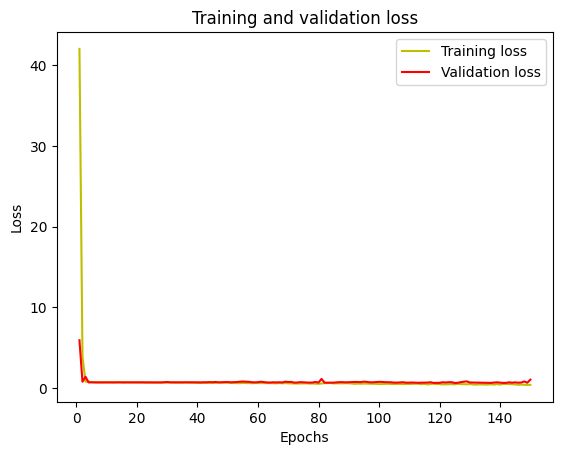

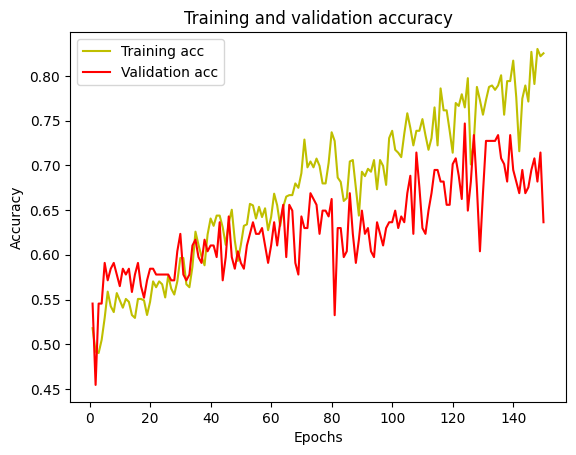

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()